In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from configs import TRAIN_DATA_FOLDER, TEST_DATA_FOLDER

In [8]:
# Set the root to train/test dataframes
train_image_dir = os.path.join('data', TRAIN_DATA_FOLDER)
test_image_dir = os.path.join('data', TEST_DATA_FOLDER)

# Split into training and validation groups
We stratify by the number of boats appearing so we have nice balances in each set

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
187873,f9dec055e.jpg,0,0.0,[0.0],122.310547
65235,56dd5f50a.jpg,0,0.0,[0.0],97.367188
40160,359cade72.jpg,3,1.0,[1.0],152.982422
89783,773d798f3.jpg,2,1.0,[1.0],183.752930
144074,bf90061cf.jpg,1,1.0,[1.0],86.782227
19508,19ec15319.jpg,0,0.0,[0.0],144.389648
66040,57e730c09.jpg,2,1.0,[1.0],139.417969
139946,b9f0a309b.jpg,1,1.0,[1.0],134.833984
112271,9549df2f3.jpg,0,0.0,[0.0],124.746094
138385,b7e50b237.jpg,0,0.0,[0.0],112.854492


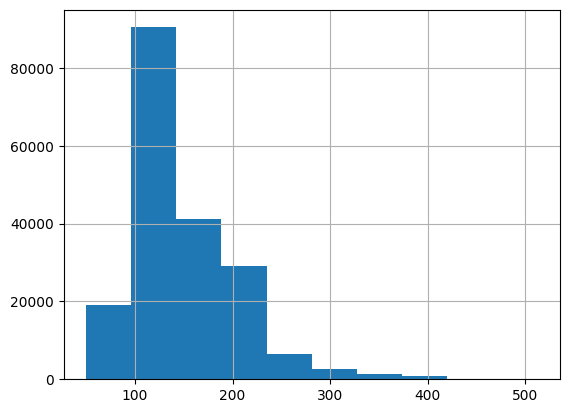

In [9]:
masks = pd.read_csv(os.path.join('data', 'train_ship_segmentations_v2.csv'))
# Make "ships" column and set 1 if the file has mask coordinates in 'EncodedPixels' row
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)

# Sake unique_img_ids dataframe with ImageId, numbers of ships in file and with file size columns
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

# Some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id:
                                                               os.stat(os.path.join(train_image_dir,
                                                                                    c_img_id)).st_size/1024)
# Keep only +50kb files
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50]
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(10)

# Examine Number of Ship Images
Here we examine how often ships appear and replace the ones without any ships with 0

<Axes: >

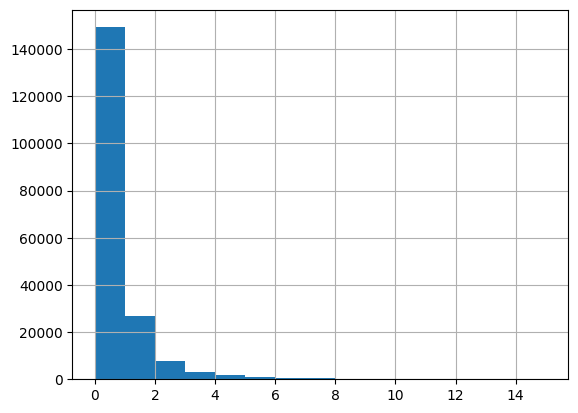

In [10]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

# Undersample Empty Images
Here we undersample the empty images to get a better balanced group with more ships to try and segment

12788 masks


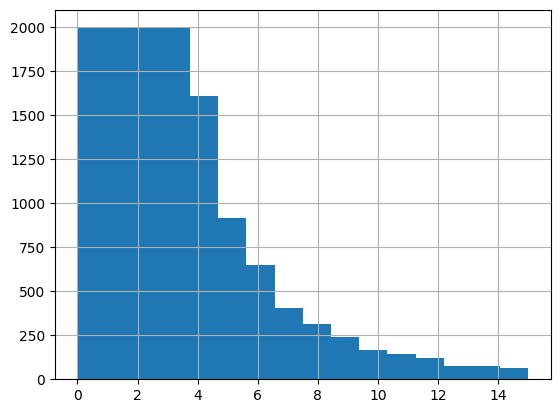

In [11]:
SAMPLES_PER_GROUP = 2000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

# Prepare test and validation dataframes

In [12]:
train_ids, valid_ids = train_test_split(balanced_train_df,
                 test_size = 0.2,
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)

# Save train and validation dataframes
train_df.to_csv('data/train.csv')
valid_df.to_csv('data/valid.csv')

print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

35364 training masks
8838 validation masks
